# `BUILDING A ML MODEL TO PREDICT ETA FOR YASSIR RIDE HAILING COMPANY` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to predict the eta for yassir to improve reliability and attractiveness to customers.

#### `Null Hypothesis`
There is no relationship between the mean of eta of trip distances above trip distance mean and mean of eta of all trips

#### `Alternate Hypothesis`
There is a relationship between the mean of eta of trip distances above trip distance mean and mean of eta of all trips

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;

• Model Accuracy : The ability of the machine learning model to have minimum margin of error

• Model Interpretability : The degree to which the model's predictions and insights can be understood and utilized by stakeholders.

#### `Analytical Questions`

- Which days of the month has the highest ride orders?
- Which hours of the day have the maximum ride orders?
- Which hours of the day have the lowest ride orders?
- Does wind speed impact ETA?
- Is Trip distance and ETA affected by dewpoint in the early hours of the day?
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

## `Data Understanding`

#### Data Source
The data was sourced from Zindi website:
- A train dataset 
- A weather dataset
- A test dataset
 

#### Data Features

- TimeStamp: Identifies the store at which the products are sold.

- Origin_Lat,Origin_Lon : Pickup point

- Destination_lat,Destination_Lon : Dropoff point

- ETA : Estimated Time of arrival

- Trip distance : Distance between origin gps coordinates and destination gps coordinates 



#### Data Exploration

##### `Libraries`

In [3]:
#Libraries imported
import pandas as pd
import numpy as np
from scipy import stats 
# from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.svm import SVR 
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV




In [4]:
##Accessing the train data 
df = pd.read_csv("data/train_data.csv",parse_dates = ['Timestamp'])
df.tail(10)
print(len(df))

83924


In [5]:
##Accessing the weather data 
w_df = pd.read_csv("data/Weather_data.csv",parse_dates = ['date'])
w_df.head(10)

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364
5,2019-11-06,283.408783,292.336121,289.727631,101370.937500,287.188354,100318.976562,0.005435,5.762590,0.564045
6,2019-11-07,283.211395,293.419891,290.415192,101249.843750,286.823730,100201.875000,0.000248,4.003057,2.685759
7,2019-11-08,281.389923,290.577393,288.396332,101331.351562,286.591522,100274.304688,0.005572,6.604807,0.676897
8,2019-11-09,280.681366,291.216400,289.184479,101801.195312,286.891205,100742.281250,0.000360,7.459220,0.228752
9,2019-11-10,282.495880,287.458679,286.003326,101158.304688,283.836639,100094.710938,0.029922,4.831686,0.762374


In [6]:
#Split Datetime 
# Extract date into a new column
df['date'] = df['Timestamp'].dt.date
df.head(3)


,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10
2,001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23


In [7]:
#merge the two datasets
# Convert 'date' columns to datetime
df['date'] = pd.to_datetime(df['date'])
w_df['date'] = pd.to_datetime(w_df['date'])

# Merge DataFrames on 'date' column

merged_df = pd.merge(df, w_df, on='date', how='left')
print(len(merged_df))

83924


In [8]:
merged_df['day']= merged_df['date'].dt.day_name()
merged_df['daynumber']= merged_df['date'].dt.day
merged_df['hour']= merged_df['Timestamp'].dt.hour
merged_df.head(5)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,dewpoint_2m_temperature,...,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,day,daynumber,hour
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,283.047546,...,286.984436,100523.062500,286.001770,99474.218750,5.779734e-03,1.914582,2.437786,Wednesday,4,20
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,282.286621,...,286.988831,102472.148438,283.798737,101401.242188,1.321921e-03,2.550383,-1.544611,Tuesday,10,22
2,001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,284.370819,...,289.942078,100172.914062,287.650238,99133.382812,9.119542e-03,6.637992,3.548401,Saturday,23,20
3,002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,284.528839,...,288.691711,101382.914062,285.940430,100338.460938,1.860000e-09,-0.076007,1.090132,Sunday,1,5
4,0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,281.457794,...,291.200867,100634.460938,287.550262,99595.820312,5.368199e-04,-1.770811,2.670749,Tuesday,17,20


### DATA UNDERSTANDING

In [9]:
#Checking for missing values
merged_df.isnull().sum()

ID                            0
Timestamp                     0
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
date                          0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
day                           0
daynumber                     0
hour                          0
dtype: int64

In [10]:
# Describing the Dataframe
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID,83924,83924,ZZZY11ZN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,83924,NaN,NaN,NaN,2019-12-04 14:22:20.568883712+00:00,2019-11-19 23:00:08+00:00,2019-11-27 01:53:00.500000+00:00,2019-12-04 01:46:50.500000+00:00,2019-12-11 21:36:44+00:00,2019-12-19 23:59:29+00:00,NaN
Origin_lat,83924.0,NaN,NaN,NaN,3.052406,2.807,2.994,3.046,3.095,3.381,0.096388
Origin_lon,83924.0,NaN,NaN,NaN,36.739358,36.589,36.721,36.742,36.76,36.82,0.032074
Destination_lat,83924.0,NaN,NaN,NaN,3.056962,2.807,2.995,3.049,3.109,3.381,0.10071
Destination_lon,83924.0,NaN,NaN,NaN,36.737732,36.596,36.718,36.742,36.76,36.819,0.032781
Trip_distance,83924.0,NaN,NaN,NaN,13527.82141,1.0,6108.0,11731.5,19369.0,62028.0,9296.716006
ETA,83924.0,NaN,NaN,NaN,1111.697762,1.0,701.0,1054.0,1456.0,5238.0,563.565486
date,83924,NaN,NaN,NaN,2019-12-03 22:34:17.633096704,2019-11-19 00:00:00,2019-11-27 00:00:00,2019-12-04 00:00:00,2019-12-11 00:00:00,2019-12-19 00:00:00,NaN


##### General Observation
- There are 83924 trips recorded in the time period
- Highest ETA recorded is 5238 secs while the average ETA is 111.69 secs
- Average trip distance is 13527.82 m

### EDA

### Univariate Analysis

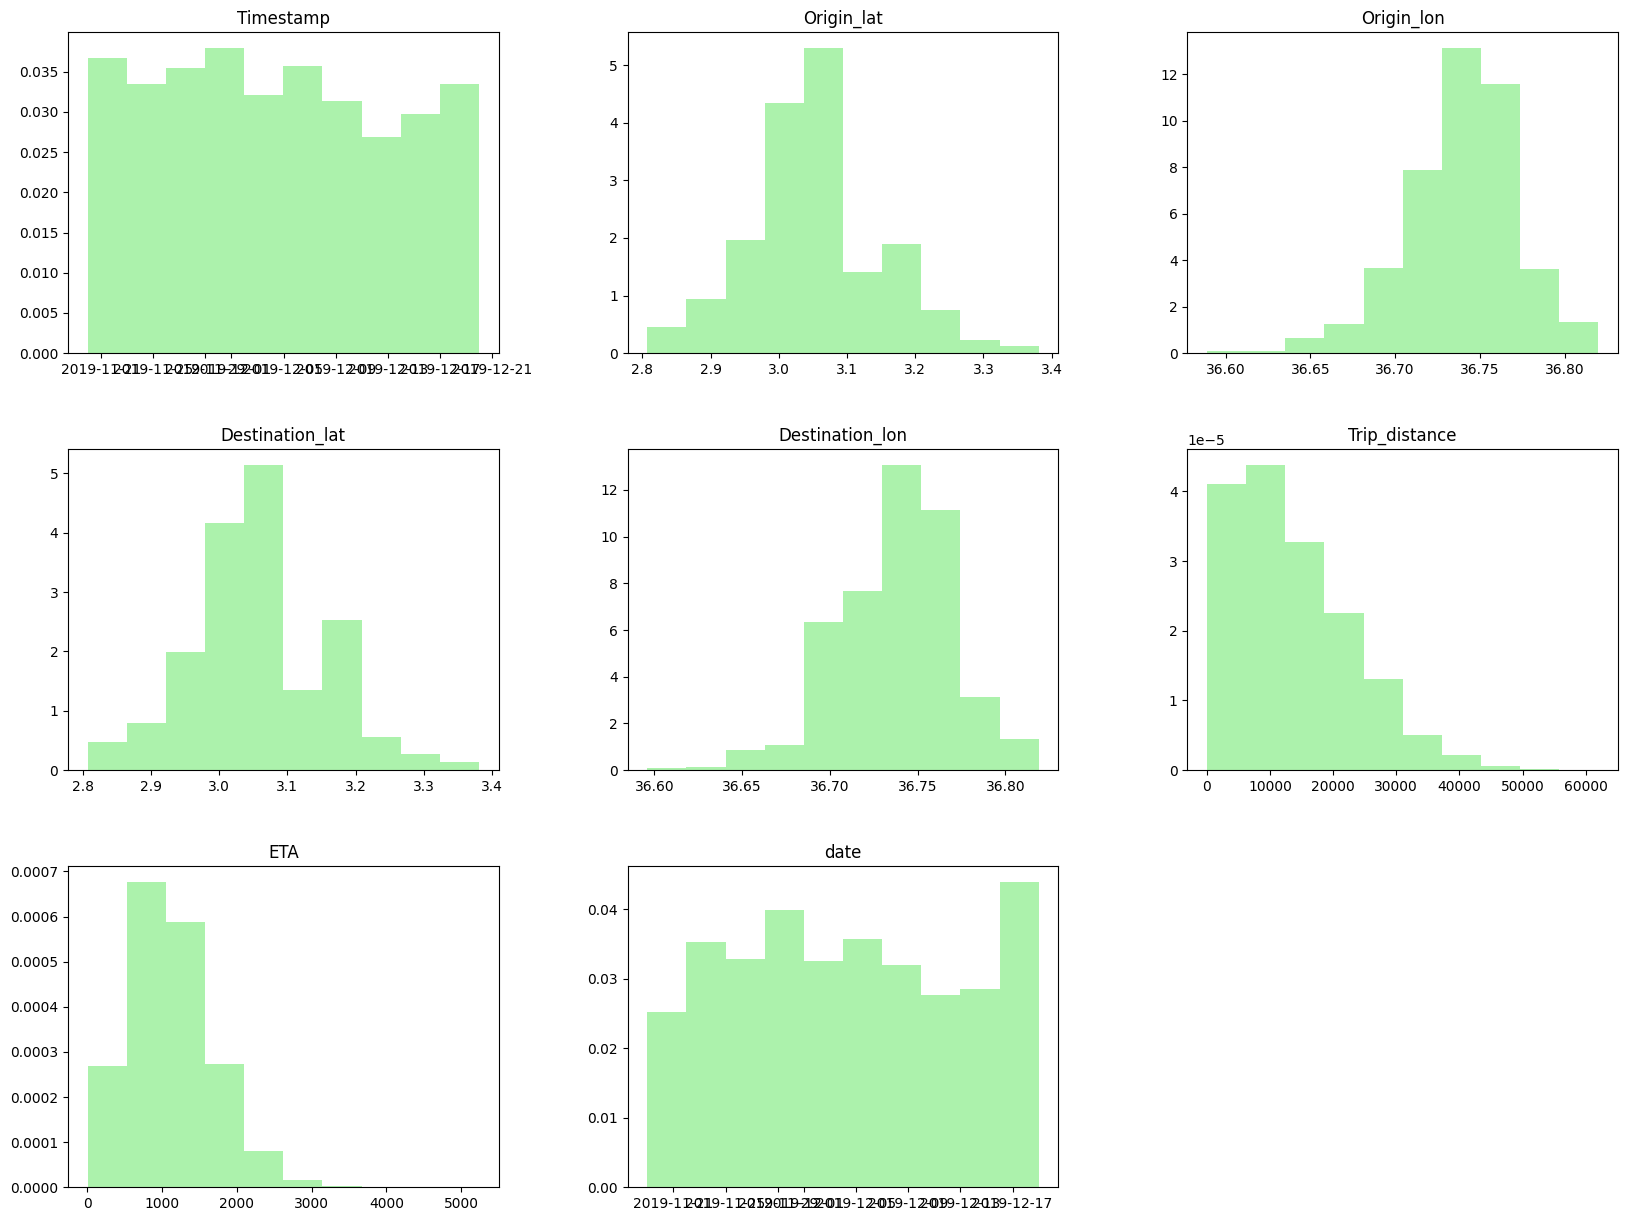

In [11]:
# Distribution of the variables
df.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()

##### BiVariate Analysis

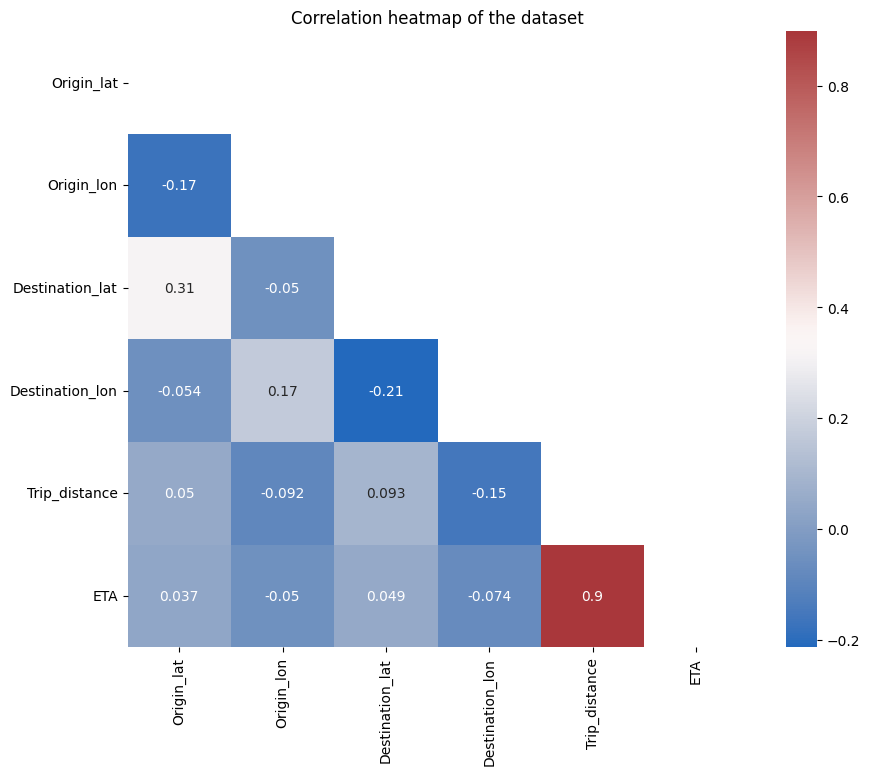

In [12]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

## `Answering the Analytical Questions`

- Which days of the month has the highest ride orders?
- Which hours of the day have the maximum ride orders?
- Which hours of the day have the lowest ride orders?
- Does wind speed impact ETA?
- Is Trip distance and ETA affected by dewpoint in the early hours of the day?
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

##### `Which days of the month has the highest ride orders?`

In [13]:
analytic_data = df.copy()
analytic_data['day']= analytic_data['date'].dt.day_name()
analytic_data.head(5)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,day
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,Wednesday
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,Tuesday
2,001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,Saturday
3,002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,Sunday
4,0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,Tuesday


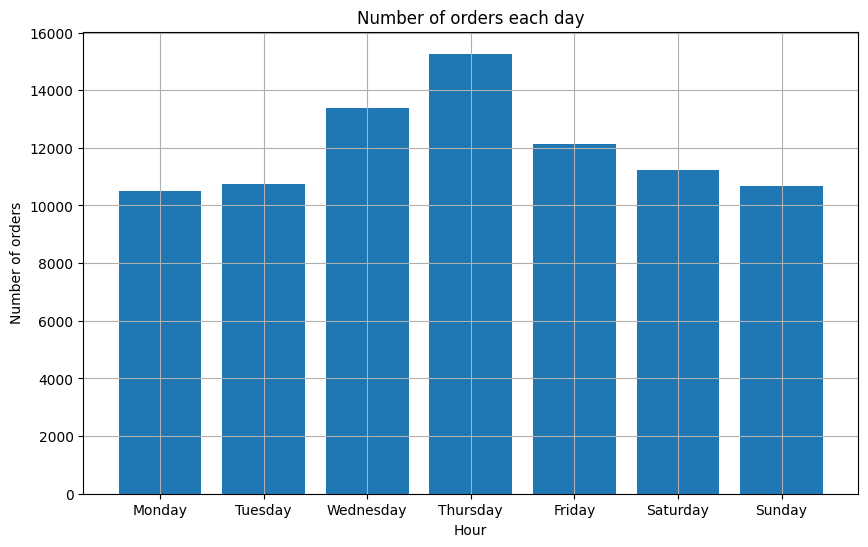

In [14]:
filt = analytic_data.groupby('day')['ETA'].count()
filt = filt.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(filt.index, filt.values)
plt.title('Number of orders each day')
plt.xlabel('Hour')
plt.ylabel('Number of orders')
plt.grid(True)
plt.show()

##### `Which hours of the day have the highest ride orders?`

In [15]:
analytic_data['hour']= analytic_data['Timestamp'].dt.hour
analytic_data

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,day,hour
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,2019-12-04,Wednesday,20
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2019-12-10,Tuesday,22
2,001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,2019-11-23,Saturday,20
3,002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,2019-12-01,Sunday,5
4,0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,2019-12-17,Tuesday,20
...,...,...,...,...,...,...,...,...,...,...,...
83919,ZZXN4JH2,2019-11-30 23:21:58+00:00,3.121,36.743,3.032,36.770,10321,664,2019-11-30,Saturday,23
83920,ZZXQ5AQJ,2019-11-27 05:59:31+00:00,3.024,36.749,2.951,36.735,10791,1056,2019-11-27,Wednesday,5
83921,ZZXYPKGU,2019-12-06 05:04:06+00:00,3.189,36.721,3.186,36.721,1139,296,2019-12-06,Friday,5
83922,ZZYTQHKT,2019-12-07 05:55:22+00:00,3.046,36.738,2.986,36.766,10637,895,2019-12-07,Saturday,5


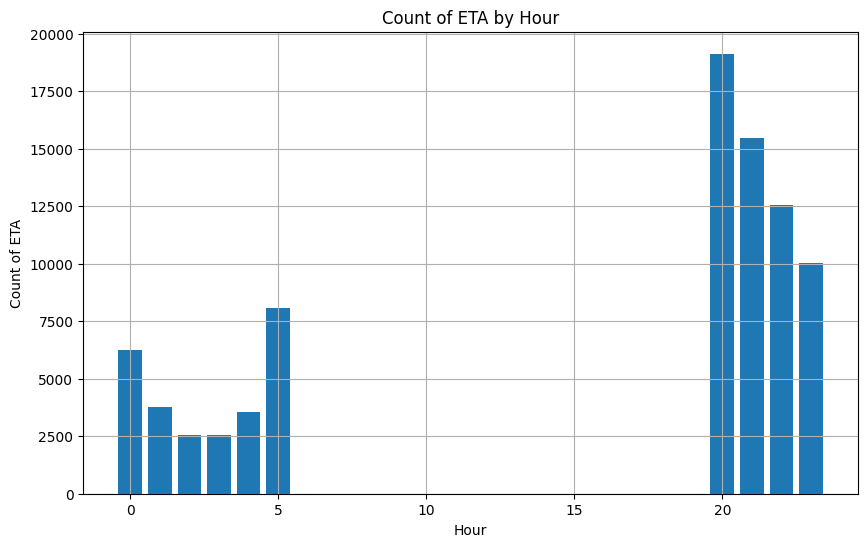

In [16]:
filt=analytic_data.groupby('hour')['ETA'].count()

filt = filt.reindex([0,1,2,3,4,5,20,21,22,23,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(filt.index, filt.values)
plt.title('Count of ETA by Hour')
plt.xlabel('Hour')
plt.ylabel('Count of ETA')
plt.grid(True)
plt.show()

##### `Does wind speed impact ETA?`

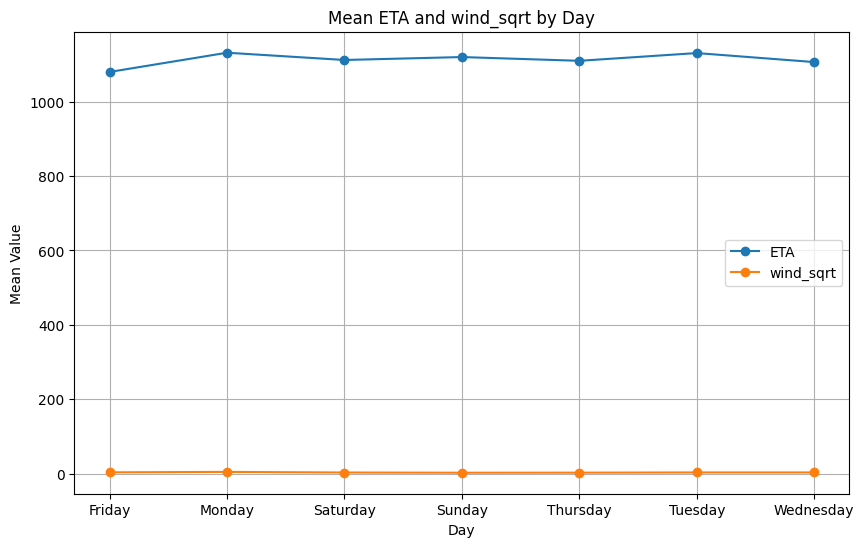

In [17]:
# Calculating wind speed
merged_df['wind_sqrt'] = np.sqrt((merged_df['u_component_of_wind_10m'] ** 2) + (merged_df['v_component_of_wind_10m'] ** 2))

filt=merged_df.groupby('day')[['ETA','wind_sqrt']].mean()
# Plotting
plt.figure(figsize=(10, 6))

# Plot ETA
plt.plot(filt.index, filt['ETA'], label='ETA', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['wind_sqrt'], label='wind_sqrt', marker='o')

# Adding title and labels
plt.title('Mean ETA and wind_sqrt by Day')
plt.xlabel('Day')
plt.ylabel('Mean Value')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

##### `Is Trip distance and ETA affected by dewpoint in the early hours of the day?'

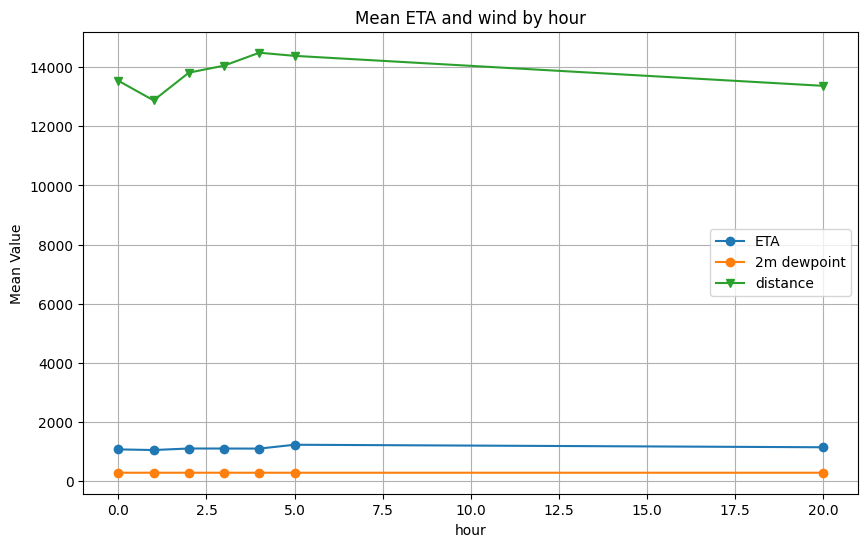

In [18]:
filt=merged_df.groupby('hour')[['Trip_distance','ETA','dewpoint_2m_temperature']].mean().head(7)
# Plotting
plt.figure(figsize=(10, 6))

# Plot ETA
plt.plot(filt.index, filt['ETA'], label='ETA', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['dewpoint_2m_temperature'], label='2m dewpoint', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['Trip_distance'], label='distance', marker='v')

# Adding title and labels
plt.title('Mean ETA and wind by hour')
plt.xlabel('hour')
plt.ylabel('Mean Value')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

#### `HYPOTHESIS`

In [19]:


distance_above_mean = merged_df.loc[(merged_df['Trip_distance'] > merged_df.Trip_distance.mean())]

# Perform t-test
t_stat, p_value = ttest_ind(distance_above_mean.ETA, merged_df.ETA)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The difference between the group means is statistically significant.")
    print(f"Reject null hypothesis >> Since the p_value {p_value} is less than 0.05")
else:
    print("The difference between the group means is not statistically significant.")
    print(f"Fail to reject null hypothesis >> Since the p_value {p_value} is greater than 0.05")

t-statistic: 139.56102603903736, p-value: 0.0
The difference between the group means is statistically significant.
Reject null hypothesis >> Since the p_value 0.0 is less than 0.05


### `Data preparation`
## `Feature Engineering`

<Axes: xlabel='wind_sqrt', ylabel='Density'>

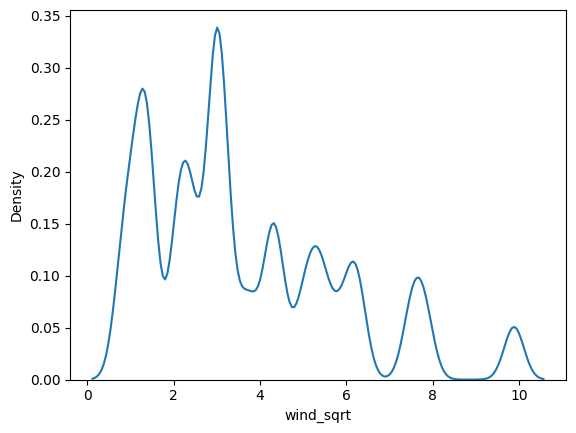

In [20]:
# Apply log transformation to 'feature1'
merged_df['log_eta'] = np.log1p(merged_df['ETA'])
#merged_df['log_surface_pressure'] = np.log1p(merged_df['surface_pressure'])
#merged_df['log_mean_sea_level'] = np.log1p(merged_df['mean_sea_level_pressure'])
merged_df['log_mean_2m_air_temperature'] = np.log1p(merged_df['mean_2m_air_temperature'])

#cube root
merged_df['log_Trip_distance'] = np.cbrt(merged_df['Trip_distance'])

# Apply inverse log transformation to 'log_feature1'
merged_df['log_total_precipitation'] = np.expm1(merged_df['total_precipitation'])



# Apply Gaussian filter with a sigma of 1
merged_df['gaussian_surface_pressure'] = gaussian_filter1d(merged_df['surface_pressure'], sigma=1)
merged_df['gaussian_mean_sea_level'] = gaussian_filter1d(merged_df['mean_sea_level_pressure'], sigma=1)
merged_df['gaussian_mean_total_precipitation'] = gaussian_filter1d(merged_df['log_total_precipitation'], sigma=4)
merged_df['gaussian_dewpoint_2m_temperature'] = gaussian_filter1d(merged_df['dewpoint_2m_temperature'], sigma=1)



#sns.kdeplot(merged_df['surface_pressure'])
sns.kdeplot(merged_df['wind_sqrt'])


In [21]:
def cleaner(df,w_df):
    df['date'] = df['Timestamp'].dt.date
    df['date'] = pd.to_datetime(df['date'])
    w_df['date'] = pd.to_datetime(w_df['date'])

    # Merge DataFrames on 'date' column

    merged_df = pd.merge(df, w_df, on='date', how='left')
    merged_df['day']= merged_df['date'].dt.day_name()
    merged_df['daynumber']= merged_df['date'].dt.day
    merged_df['hour']= merged_df['Timestamp'].dt.hour

    # Calculating wind speed
    merged_df['wind_sqrt'] = np.sqrt((merged_df['u_component_of_wind_10m'] ** 2) + (merged_df['v_component_of_wind_10m'] ** 2))
    # Apply log transformations
    merged_df['log_eta'] = np.log1p(merged_df['ETA'])
    merged_df['log_mean_2m_air_temperature'] = np.log1p(merged_df['mean_2m_air_temperature'])

    #Apply cube root transformations
    merged_df['log_Trip_distance'] = np.cbrt(merged_df['Trip_distance'])

    # Apply inverse log transformation
    merged_df['log_total_precipitation'] = np.expm1(merged_df['total_precipitation'])


    #Smoothening some columns

    # Apply Gaussian filter with a sigma of 1
    merged_df['gaussian_surface_pressure'] = gaussian_filter1d(merged_df['surface_pressure'], sigma=1)
    merged_df['gaussian_mean_sea_level'] = gaussian_filter1d(merged_df['mean_sea_level_pressure'], sigma=1)
    merged_df['gaussian_mean_total_precipitation'] = gaussian_filter1d(merged_df['log_total_precipitation'], sigma=4)
    merged_df['gaussian_dewpoint_2m_temperature'] = gaussian_filter1d(merged_df['dewpoint_2m_temperature'], sigma=1)

    return merged_df

In [22]:
data = cleaner(df,w_df)

In [23]:
merged= merged_df.copy()

In [24]:
# Select columns of interest
selected_columns = merged_df[['Timestamp','date','daynumber','hour','log_mean_2m_air_temperature','gaussian_surface_pressure','gaussian_dewpoint_2m_temperature',
                              'gaussian_mean_sea_level','gaussian_mean_total_precipitation','wind_sqrt','log_Trip_distance','Trip_distance','log_eta','ETA']]

KeyError: "['boxcox_log_eta'] not in index"

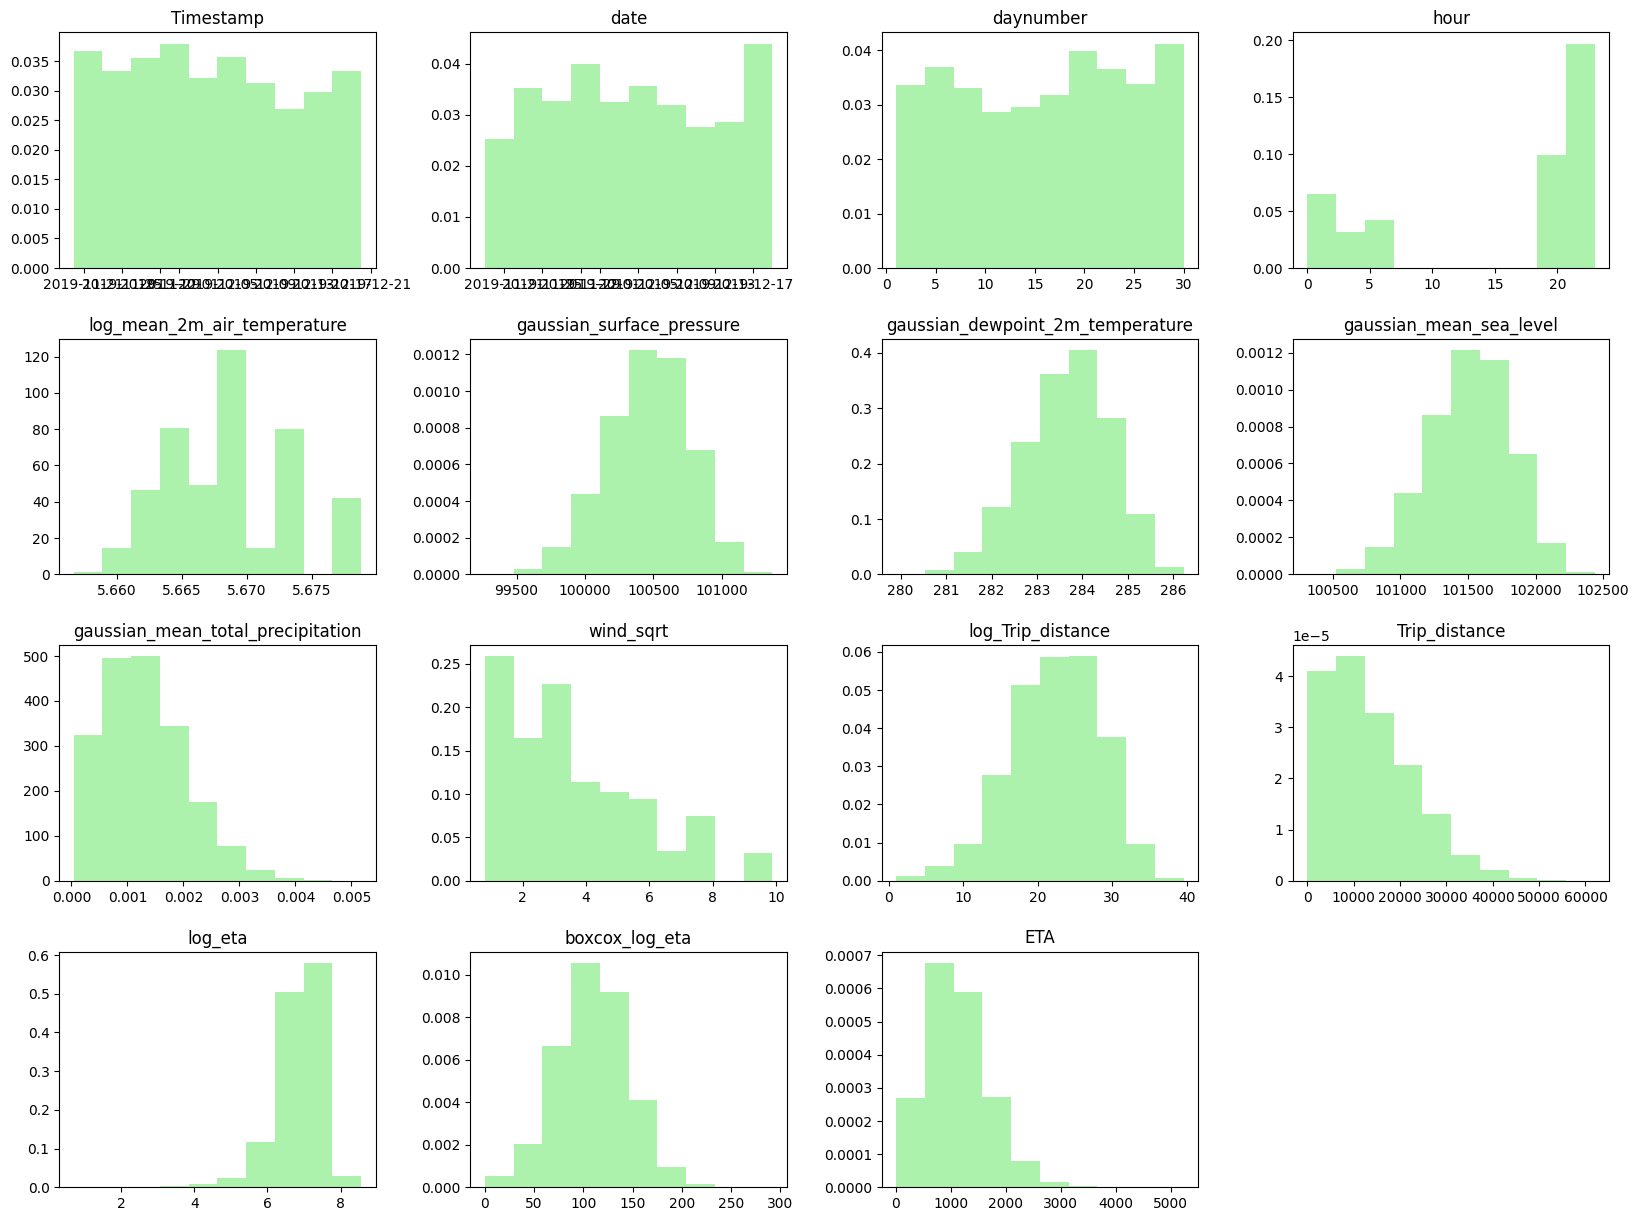

In [ ]:
# Distribution of the variables
selected_columns.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()

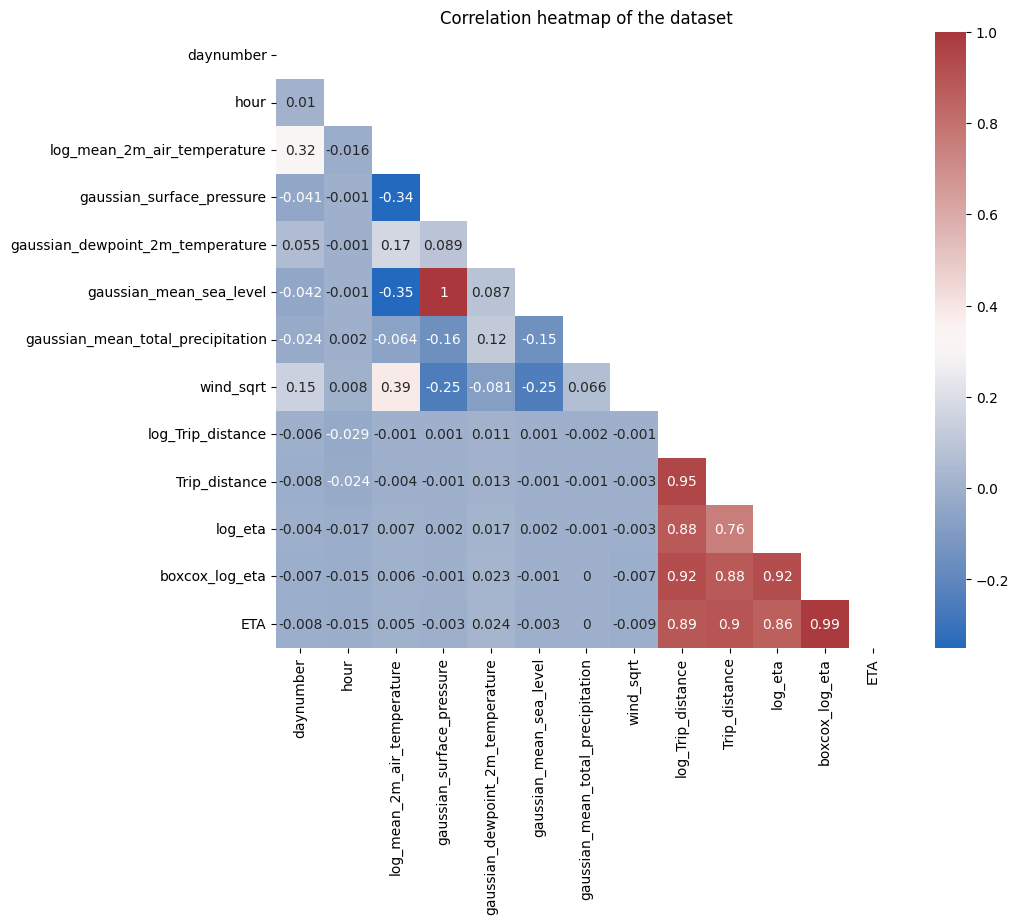

In [ ]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = selected_columns.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [ ]:
first_500 = selected_columns.head(80000)
first_500.head(3)

,Timestamp,date,daynumber,hour,log_mean_2m_air_temperature,gaussian_surface_pressure,gaussian_dewpoint_2m_temperature,gaussian_mean_sea_level,gaussian_mean_total_precipitation,wind_sqrt,log_Trip_distance,Trip_distance,log_eta,boxcox_log_eta,ETA
0,2019-12-04 20:01:50+00:00,2019-12-04,4,20,5.662906,100028.595049,282.906201,101083.402997,0.003015,3.099746,34.092883,39627,7.932003,198.630099,2784
1,2019-12-10 22:37:09+00:00,2019-12-10,10,22,5.662922,100216.330282,283.134109,101271.536033,0.002887,2.981656,15.764788,3918,6.357842,75.584790,576
2,2019-11-23 20:36:10+00:00,2019-11-23,23,20,5.673124,100024.562454,283.670294,101073.402700,0.002650,7.526891,19.367722,7265,6.267201,71.457453,526


'Timestamp','date','daynumber','hour','log_mean_2m_air_temperature','gaussian_surface_pressure',
                              'gaussian_mean_sea_level','gaussian_mean_total_precipitation','wind_sqrt','log_Trip_distance','log_eta','ETA']]

In [ ]:
X=selected_columns.drop(columns=['date','daynumber','hour','Trip_distance','Timestamp',
                              'gaussian_mean_total_precipitation','ETA','log_eta','wind_sqrt'],axis=1)
y=selected_columns['log_eta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 27)

In [ ]:
X.head(3)

,log_mean_2m_air_temperature,gaussian_surface_pressure,gaussian_dewpoint_2m_temperature,gaussian_mean_sea_level,log_Trip_distance
0,5.662906,100028.595049,282.906201,101083.402997,34.092883
1,5.662922,100216.330282,283.134109,101271.536033,15.764788
2,5.673124,100024.562454,283.670294,101073.402700,19.367722


In [ ]:
y

0        7.932003
1        6.357842
2        6.267201
3        8.049108
4        7.668094
           ...   
83919    6.499787
83920    6.963190
83921    5.693732
83922    6.797940
83923    6.484635
Name: log_eta, Length: 83924, dtype: float64

In [ ]:
# create an SVR model with a linear kernel 
model= SVR(kernel='rbf',max_iter = 2000,gamma = 'auto') 
model.fit(X_train, y_train)

SVR(gamma='auto', max_iter=2000)

In [ ]:
# Predictions
y_pred= (model.predict(X_test))

In [ ]:
# Compute the inverse log (exponential)
original_values = np.expm1(y_pred) #np.power(2, y_pred)
#np.expm1(y_pred)

print(original_values)

[ 794.86252613 1364.28468088  488.18805908 ... 1079.42447903  772.03221891
 1165.05960149]


In [ ]:
# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 344.09383142193354
Mean Squared Error (MSE): 233465.5122100875
Root Mean Squared Error (RMSE): 483.18269030469986


In [ ]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
# Predictions
y_pred= (model.predict(X_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 41962, number of used features: 5
[LightGBM] [Info] Start training from score 6.840164


In [ ]:
# Compute the inverse log (exponential)
original_values = y_pred

print(original_values)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


[6.75053708 7.59542076 6.22641642 ... 7.26652042 7.04573914 7.43134184]
Mean Absolute Error (MAE): 168.4932908291703
Mean Squared Error (MSE): 56008.88755390824
Root Mean Squared Error (RMSE): 236.66196896398085


In [ ]:
# Initialize the XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 168.32658929419378
Mean Squared Error (MSE): 56021.142233165905
Root Mean Squared Error (RMSE): 236.68785822928456


In [ ]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 233.78995281445117
Mean Squared Error (MSE): 108240.9568180735
Root Mean Squared Error (RMSE): 328.99993437396535


In [ ]:
# Initialize and train the model
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 214.0147905324329
Mean Squared Error (MSE): 89881.19280243963
Root Mean Squared Error (RMSE): 299.80192261298066


In [ ]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 191.25915061143007
Mean Squared Error (MSE): 71407.07746403737
Root Mean Squared Error (RMSE): 267.2210273613163


In [ ]:
# Create a dictionary of the model pipelines
all_models_pipelines = {
              "Linear_Regression": LinearRegression(n_jobs=-1),
              "SVR": SVR(kernel='rbf',max_iter = 2000,gamma = 'auto'),
              "Xgboost":XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
              "LBM" : lgb.LGBMRegressor(),
              "D_Tree" : DecisionTreeRegressor(random_state=42),
              "K-NN" : KNeighborsRegressor(n_neighbors=5),
              }
    

In [ ]:
def evaluate_models(model_pipelines = all_models_pipelines, X_test = X_test, y_test = y_test):


    # Dictionary for trained models
    trained_models = dict()

    # Create a dataframe matrix to all pipelines
    all_confusion_matrix = []
    
    
    # List to receive scores
    performances = []
    for name, model_pipeline in model_pipelines.items():
        final_pipeline = model_pipeline
    


        
        final_pipeline.fit(X_train,  y_train)
       

        # Predict and calculate performance scores
        y_pred = final_pipeline.predict(X_test)
        performances.append([name,
                             mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
                             mean_squared_error(np.expm1(y_test), np.expm1(y_pred)),
                             np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
                             ])


        # Store trained model
        trained_model_name = "trained_" + str(name).lower()
        trained_models[trained_model_name] = final_pipeline
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6)
        # Compile accuracy
    df_compare = pd.DataFrame(performances, columns = ["model", "mae", "mse", "rsme"])
    df_compare.set_index("model", inplace = True)
    df_compare.sort_values(by = ["rsme", "mae"], ascending = False, inplace=True)
    return df_compare, trained_models

In [ ]:
# Run the function to train models and return performances
all_models_eval, trained_models = evaluate_models()
all_models_eval


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 41962, number of used features: 5
[LightGBM] [Info] Start training from score 6.840164

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----

 -----   -

,mae,mse,rsme
model,,,
SVR,344.093831,233465.512210,483.182690
D_Tree,233.789953,108240.956818,328.999934
Linear_Regression,214.014791,89881.192802,299.801923
K-NN,191.259151,71407.077464,267.221027
Xgboost,168.326589,56021.142233,236.687858
LBM,168.493291,56008.887554,236.661969


#### `HYPERPARAMETER TUNING`

In [ ]:
# Define the parameter grid
param_grid = {
    'booster' : ['dart'],
    'n_estimators': [200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 7],
    'min_child_weight': [1, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 1.0]
}

xg_reg = XGBRegressor(objective='reg:squarederror')

# Perform grid search
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")



Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
# Define the model
lgb_reg = lgb.LGBMRegressor()

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 70],
    'max_depth': [-1, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")



Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 27974, number of used features: 5
[LightGBM] [Info] Start training from score 6.842345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 27975, number of used features: 5
[LightGBM] [Info] Start training from score 6.837377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 27

`Persisting the model`
### Saving the model

In [ ]:
# for name, model_pipeline in all_models_pipelines.items():
#     joblib.dump(model_pipeline,f'models\{name}.joblib')

NameError: name 'joblib' is not defined

In [ ]:
# joblib.dump(best_gs_pred ,'models\\tuned\\best_gs_pred .joblib')
# joblib.dump(best_search_pred,'models\\tuned\\best_search_pred.joblib')
# joblib.dump(best_catboost_pred,'models\\tuned\\best_catboost_pred.joblib')
# joblib.dump(best_svc_pred,'models\\tuned\\best_svc_pred.joblib')